## What is style transfer?
- Take style from source image and add to content of target image while still preserving semantic content of target image.
- Already exist many non-parametric algorithms for texture synthesis, but suffer from one fundamental problem: only use the low-level image features of the target image

- This paper introduces **A Neural Algorithm of Artistic Style**, where you start off with a "noise image" and reconstruct it with style and content
  - Fix weights of CNN and update noise image

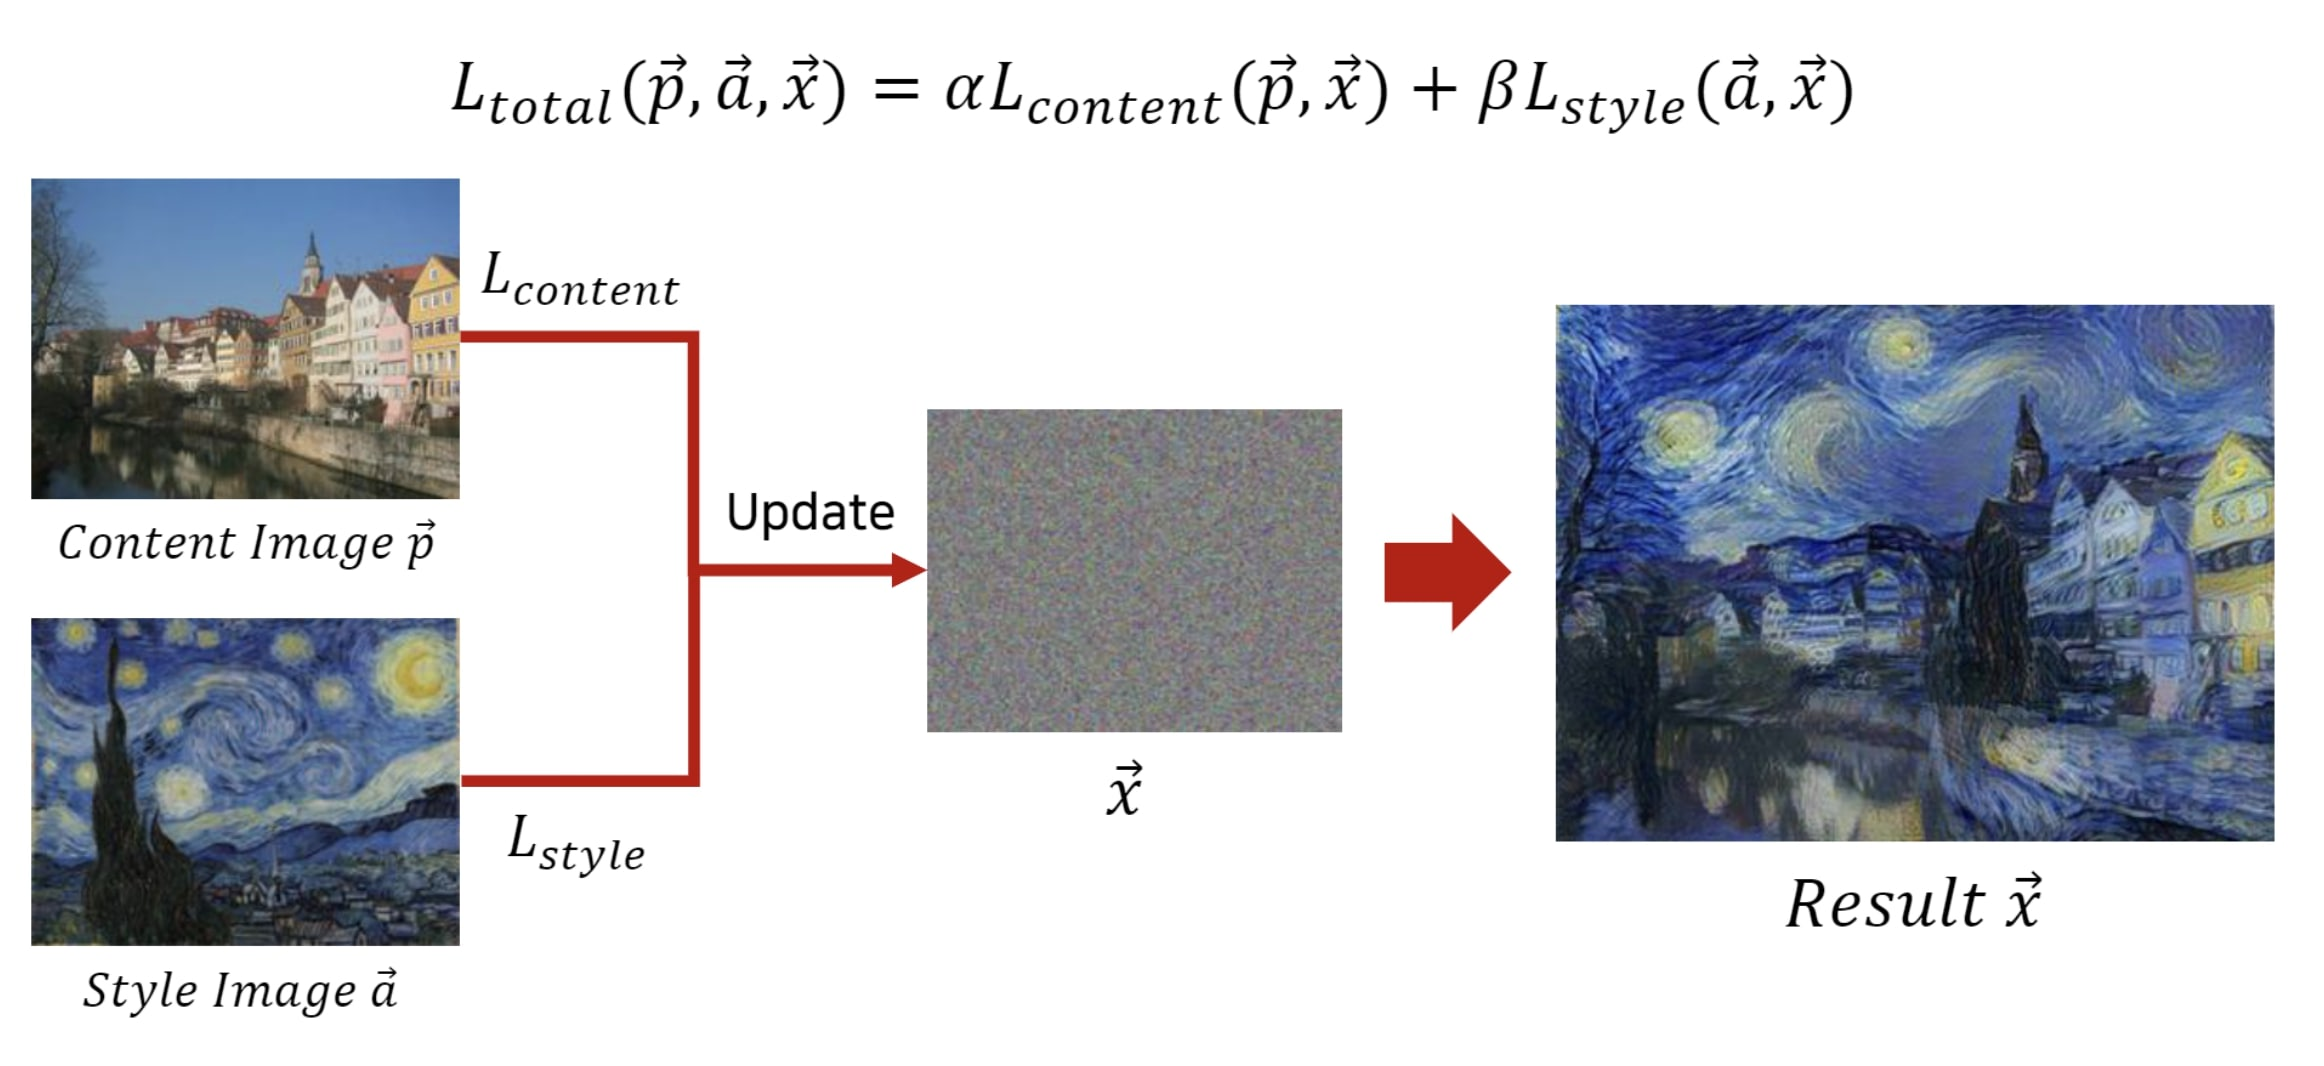

# Content Representation

Content loss function:
$L_{content}(\vec p, \vec x, l) = \frac{1}{2}\sum (F_{ij}^l - P_{ij}^l)^2$.
  - p: content image
  - x: input image (noise)
  - l: lth layer
  - P: p's feature representation in layer l
  - F: x's feature representation in layer l

- It is expressed as an F matrix corresponding to the ith filter existing in the Lth convolution layer.

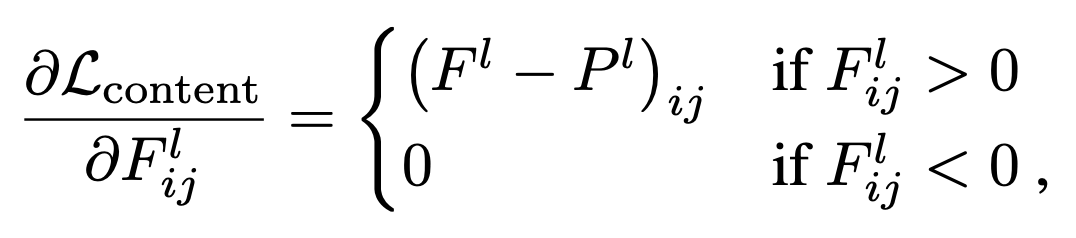

In [13]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import os
import tensorflow_probability as tfp


In [14]:
CONTENT_LAYERS = "block5_conv2"
STYLE_LAYER_NAMES = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
CONTENT_WEIGHT = 8e-4
STYLE_WEIGHT = 8e-1
RESIZE_HEIGHT = 607
NUM_ITER = 3000

In [15]:
def preprocess_img(img_path, target_height, target_width):
  img = keras.utils.load_img(img_path, target_size=(target_height, target_width))
  img_array = keras.utils.img_to_array(img)

  # add a batch dimension, converting the shape from (height, width, channels) to (1, height, width, channels)
  img_array = np.expand_dims(img_array, axis=0)

  # preprocess the image using the VGG19 preprocessing function
  img_array = vgg19.preprocess_input(img_array)

  return tf.convert_to_tensor(img_array)


In [16]:
def vgg19_model():
  # include_top: whether to include the 3 fully-connected layers at the top of the network.
  model = vgg19.VGG19(weights='imagenet', include_top=False)
  outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
  # Set up a model that returns the activation values for every layer in VGG19 (as a dict).
  return keras.Model(inputs = model.inputs, outputs = outputs_dict)

def get_optimizer():
    return keras.optimizers.Adam(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 8.0, decay_steps = 445, decay_rate = 0.98
            # initial_learning_rate = 2.0, decay_steps = 376, decay_rate = 0.98
        )
    )

In [17]:
def content_loss(content_features, target_features):
  original_img = content_features[CONTENT_LAYERS]
  generated_img = target_features[CONTENT_LAYERS]
  return tf.reduce_mean(tf.square(original_img - generated_img)) / 2


In [18]:
def gram_matrix(features):
  features = tf.transpose(features, perm=[0, 2, 1])
  features = tf.reshape(features, [-1, tf.shape(features)[-1]])
  return tf.matmul(features, tf.transpose(features))

def style_loss_contribution(style_features, target_features, feature_map_size):
  original_features = gram_matrix(style_features)
  generated_features = gram_matrix(target_features)
  num_channels = style_features.shape[2]
  loss = tf.reduce_mean(tf.square(original_features - generated_features)) / (4 * (num_channels ** 2) * (feature_map_size ** 2))
  return loss

def total_style_loss(style_features, target_features, feature_map_size):
  style_loss = 0
  for layer in STYLE_LAYER_NAMES:
    style_loss += style_loss_contribution(style_features[layer][0], target_features[layer][0], feature_map_size) / len(STYLE_LAYERS)

  return style_loss


In [19]:
def total_loss(model, target_img, content_features, style_features):
    target_features = model(target_img)
    content_loss_value = content_loss(content_features, target_features)
    style_loss_value = total_style_loss(style_features, target_features, target_img.shape[1] * target_img.shape[2])
    return CONTENT_WEIGHT * content_loss_value + STYLE_WEIGHT * style_loss_value


In [20]:
def deprocess_img(img_tensor, height, width):
  img_tensor = img_tensor.numpy()
  tensor = img_tensor.reshape((height, width, 3))
  tensor[:, :, 0] += 103.939
  tensor[:, :, 1] += 116.779
  tensor[:, :, 2] += 123.68
  tensor = tensor[:, :, ::-1]
  return np.clip(tensor, 0, 255).astype('uint8')

def save(target_img, height, width, name):
  img = deprocess_img(target_img, height, width)
  keras.utils.save_img(name, img)

In [21]:
content_img_path = 'content_img.jpg'
style_img_path = 'starry_night.jpg'

content_width, content_height = keras.preprocessing.image.load_img('content_img.jpg').size
target_width = int(content_width * 607 / content_height)
target_height = 607
print(target_height, target_width)


content_tensor = preprocess_img(content_img_path, target_height, target_width)
style_tensor = preprocess_img(style_img_path, target_height, target_width)
generated_image = tf.Variable(tf.random.uniform(style_tensor.shape, dtype=tf.dtypes.float32))

607 910


In [22]:
model = vgg19_model()
optimizer = get_optimizer()
model.summary()
content_features = model(content_tensor)
style_features = model(style_tensor)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
for iter in range(NUM_ITER):
        with tf.GradientTape() as tape:
            loss = total_loss(model, generated_image, content_features, style_features)

        grads = tape.gradient(loss, generated_image)

        print("iter: %4d, loss: %8.f" % (iter, loss))
        optimizer.apply_gradients([(grads, generated_image)])

        if (iter + 1) % 100 == 0:
            name = "result/generated_at_iteration_%d.png" % (iter + 1)
            save(generated_image, target_height, target_width, name)

name = "result/result_%d_%f_%f.png" % (NUM_ITER, CONTENT_WEIGHT, STYLE_WEIGHT)
save(generated_image, target_height, target_width, name)